In the last file, we built a very basic CNN classifier, and it didn't perform too well on our test dataset. While this is not surprising given the model's simplicity, it's not desirable, because our model was performing just as well as randomly guessing.

In this file, we'll implement a slightly more complex architecture. We'll learn about [AlexNet](https://en.wikipedia.org/wiki/AlexNet), a CNN architecture that competed in 2012's [ImageNet Challenge](https://en.wikipedia.org/wiki/ImageNet_Large_Scale_Visual_Recognition_Challenge) and outperformed other networks by a significant margin. A decade-old model might not seem relevant to us now, but the architecture’s performance on a dataset with more than a million images across 1,000 classes has since influenced the design of a lot of deep learning models in computer vision.

## Our Dataset

We'll continue working with the [beans dataset](https://github.com/AI-Lab-Makerere/ibean/) to develop a more reliable classifier that will enable the [National Crops Resources Research Institute](https://naro.go.ug/about-us/paris/nacrri/) to better equip farmers to identify, and subsequently address, diseased food crops.

As a reminder, the `beans` dataset has the following directory structure once it's been uncompressed:

To uncompress the data, we can use the following helper function:

## Loading Our Dataset

As we learned, the [`tf.keras.utils.image_dataset_from_directory()` function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) is used to load images from a directory and create a dataset from them. The `shuffle` parameter is an optional argument that, when set to `True`, shuffles the order of the images in the dataset. By default, it is set to `True`.

When `shuffle` is enabled, the image dataset's order will be randomized during each epoch. This helps to prevent any possible biases that may arise due to the original order of the images. Shuffling the dataset can lead to better generalization and model performance, as the model is less likely to rely on any specific order of the data.

Let's load in the dataset as we did in the previous lesson but this time we'll use the default value for `shuffle` by not passing this argument to the function call when we create the datasets.

In [2]:
import tensorflow as tf

train_set = tf.keras.utils.image_dataset_from_directory(
    directory='beans/train/',
    labels='inferred',
    label_mode='categorical',
    batch_size=128,
    image_size=(500, 500),
    shuffle=False)

validation_set = tf.keras.utils.image_dataset_from_directory(
    directory='beans/validation/',
    labels='inferred',
    label_mode='categorical',
    batch_size=128,
    image_size=(500, 500),
    shuffle=False)

Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.


Although it was a neural network, our model from the last file didn't fully utilize the potential of deep learning. The "deepness" refers to the number of hidden layers, as well as the width of those layers. For convolutional layers, the width of a layer is determined by the number of filters in that layer. Adding more convolutional layers with larger widths would, theoretically, allow our model to extract and learn more features from our input data.

This is also the basis of AlexNet, which has an 8-layer CNN:

-   5 convolutional layers.
-   2 fully-connected hidden layers.
-   1 output layer.

For this file, we'll implement a modified version of AlexNet. But before we can implement it, we have to preprocess our images.

When working with a dataset with multiple features, different features could have different ranges of values. One feature could unduly impact the model's pefomance more than another. We standardize or normalize our input features so all of them can be on the same scale and thereby reduce any potential bias the model might end up having towards any one feature. Additionally, training over a set of features with a smaller range of values also speeds up the training.

While exploring the `beans` dataset in the last file, we saw how different images had different lighting conditions. We want our model to be able to classify our leaves accurately, whatever the lighting. Normalizing the images could make our model more resilient to such variations across the dataset.

There are several different options for preprocessing the images. For example, we could try:

-   **Centering:** Calculate the mean value across the training set and subtract that value from each pixel across every image.
-   **Normalization:** Scale the pixel values to a range like `[0, 1]` or `[-1, 1]`. This is also referred to as rescaling the input.
-   **Standization:** Subtract the mean of the training set from each pixel across every image and divide the result by the standard deviation of the training set. Note that the terms standardization and normalization are often used interchangeably.

We will use both normalization and standardization. TensorFlow, however, refers to those terms differently:

-   Normalization is referred to as rescaling.
-   Standardization is referred to as normalization.

We will use the same terms as TensorFlow.

AlexNet incorporated the centering approach above. However, we'll rescale our input. While both are commonly-used techniques, rescaling is relatively easier to implement in TensorFlow.

As we know, in TensorFlow our data is stored in a `Dataset` object as a tuple of Tensors storing the images and labels. We only need to normalize our images, not their labels. We can use the [`map()` method](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to extract the images from our dataset:

In [3]:
train_imgs = train_set.map(lambda imgs, labels: imgs)

In [4]:
train_imgs

<_MapDataset element_spec=TensorSpec(shape=(None, 500, 500, 3), dtype=tf.float32, name=None)>

`train_imgs` will store only the images from the training set. We can then normalize these images. We first instantiate a [`Normalization` layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization):

In [5]:
normalization_layer = tf.keras.layers.Normalization(axis=-1)

Setting the `axis` to `-1` will result in the layer calculating a mean and variance for each index on the last axis. The images are stored in Tensors of shape `[32, 500, 500, 3]`. The last axis, therefore, corresponds to the RGB channels. Using the [`adapt()` method](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization#adapt), the normalization layer will calculate the mean and variance values for each channel:

In [6]:
normalization_layer.adapt(train_imgs)

The above step only uses `train_imgs` to calculate the mean and variance values. It doesn't normalize those images. Once those values are calculated, we have the normalization layer use those values to normalize the images in our training set. Since we'll need the corresponding labels for our normalized training images, we pass the labels through a lambda function without changing their values:

In [7]:
train_set_normalized = train_set.map(lambda imgs, labels: (normalization_layer(imgs), labels))

We also have to normalize our validation and test sets. If we were to take some new pictures of the leaves and input them into our model for predicting whether they are diseased, the model would likely fail because it was trained on normalized images. The model would expect input similar to the training data. That's why we need to normalize the other two datasets.

When normalizing the validation and test sets, we should use the mean and variance values obtained from the *training* set. We want our model to generalize and perform well on unseen data. We use validation and test sets in lieu of unseen data to allow us to train such a model. If we were to calulate the mean and variance of the validation and test sets separately and use those values to normalize the datasets, we would be "leaking" information about the two datasets back to our model. When information from our test or validation set is unintentionally used during the training process like this, we refer to it as data leakage.

Data leakage can end up introducing bias in our model. The model might end up performing well on the validation and test sets; however, we might not get a similar performance when we use the model to classify any new, unseen data. This would be even more of a problem if we used the model to classify a single input. We won't be able to calculate the mean and variance of a single image in order to normalize it. If we couldn't normalize that single image input, our model would likely not output an accurate prediction.

This is why we normalize our validation and test sets using the mean and variance values obtained from the training set. We'll use the same normalization layer to normalize the two other sets.

In [9]:
train_set_normalized = train_set.map(lambda imgs, labels: (normalization_layer(imgs), labels))
validation_set_normalized = validation_set.map(lambda imgs, labels: (normalization_layer(imgs), labels))

In [10]:
test_set = tf.keras.utils.image_dataset_from_directory(
    directory='beans/test/',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(500, 500))

Found 128 files belonging to 3 classes.


In [11]:
test_set_normalized = test_set.map(lambda imgs, labels: (normalization_layer(imgs), labels))

Now that we've preprocessed our inputs, we can build our model. As mentioned previously, AlexNet has 8 layers. Its architecture is depicted below. Note that AlexNet uses a different `input_shape` (227, 227) than what we've been using for the `beans` dataset (500, 500). We'll talk more about that later.

![](https://s3.amazonaws.com/dq-content/780/4.1-m780.svg)

The first layer is a convolutional layer with a filter of size `11x11`. At this stage, it's reasonable to ask what the appropriate kernel size is for a given convolutional layer. The answer is that it's a hyperparameter we can tune.

The `11x11` kernel size was selected by the creators of AlexNet to capture more of the objects in the images. Since the creation of AlexNet, both research and experiments have shown that deeper models (ones with more convolutional layers) are better than wider models (ones with larger kernels). Many CNN architectures since then have used kernels of sizes `5x5`, `3x3` etc. More layers allow the model to extract more features from previous layers. Smaller kernels also result in fewer model parameters. This topic is still being researched, though. Newer research indicates that larger filters are a viable option. That's the pattern we'll notice across these files — designing deep learning architectures is very experimental.

We also need to consider that our `beans` dataset only has images of leaves. Even with large image sizes, we don't necessarily require large filter sizes and can opt for smaller ones if we want to.

AlexNet applied padding to inputs of all convolutional layers except the first one. We might recall that we can set padding in [`Conv2D` layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) as `same` or as `valid`. AlexNet set `padding` to `valid` for the first convolutional layer and `same` for the rest. In the figure above, we can see how the padding and number of strides have an impact on outputs of each layer. We'll discuss that later.

After the first convolutional layer, the architecture used a max pooling layer with a stride of `2`. Based on the experiments the authors ran, this choice was shown to improve the model's performance. As a final note, all the layers in the model use the `ReLU` activation function.

We'll build a model with just the first two layers.

### The AlexNet architecture:

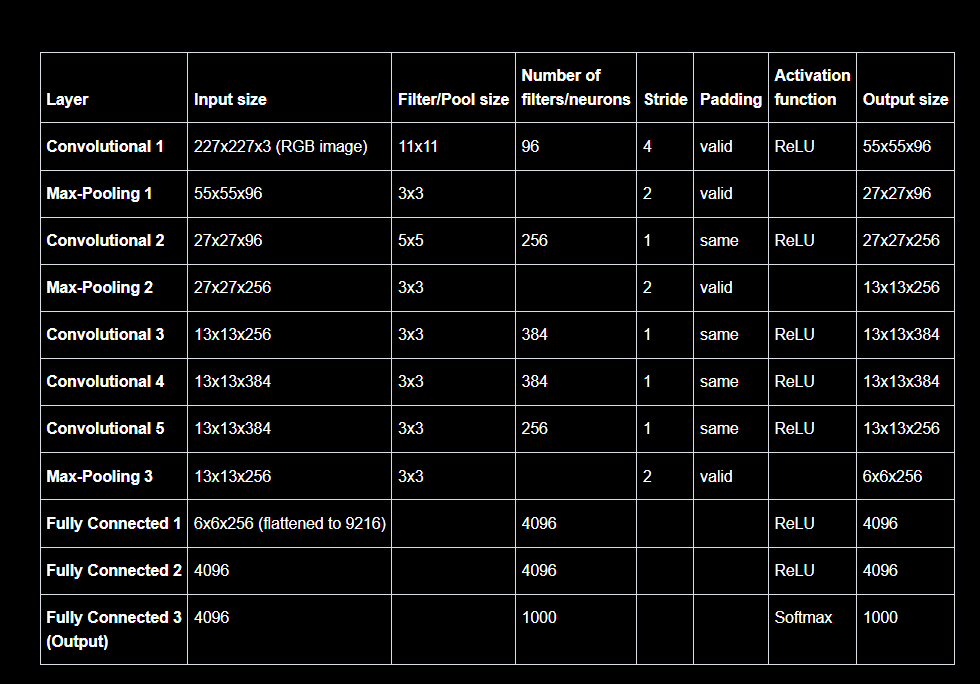

Refer to the AlexNet architecture to select the required hyperparameters for the exercise below.

In [12]:
from tensorflow.keras import layers, models

model = models.Sequential()
model.add(layers.Input(shape= (500, 500, 3)))

model.add(layers.Conv2D(filters=96, kernel_size=11,strides=4, padding="valid",activation='relu'))
model.add(layers.MaxPooling2D(pool_size=3, strides=2))

model.add(layers.Conv2D(filters=256, kernel_size=5,strides=1, padding="same",activation='relu'))

model.add(layers.MaxPooling2D(pool_size=3, strides=2))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 123, 123, 96)        │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 61, 61, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 256)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 649,600 (2.48 MB)

 Trainable params: 649,600 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

![](https://s3.amazonaws.com/dq-content/780/5.1-m780.svg)

The next 3 layers of our model are convolutional layers, with no pooling layers between them. As we know, max pooling offers multiple advantages, but not using it can allow the model to extract more features. Many modern CNN architectures follow a similar pattern of adding a pooling layer after multiple consecutive convolutional layers.

We have more layers in this model than the one we created previously. Each convolutional layer has multiple kernels. The number of kernels generally increases as we go deeper, because each subsequent layer extracts more complex features.

We previously learned how the parameters `padding` and `strides` impact a layer's output dimensions. In the AlexNet architecture, a layer with a padded input and with a stride greater than `1`, the height and width of each output of that layer is less than the input. However, when the stride is `1`, the height and width remain the same. The architecture adds more convolutional layers, but those layers don't lead to any loss of features, since the output dimensions are the same as the input's. With the large number of kernels, these consecutive convolutional layers allow the model to extract more complex features.

For our `beans` dataset, we might not need as many layers, since there aren't too many complex details in the images of the leaves. We can experiment with selecting the number of layers and deciding how to design the architecture using those layers. This is a part of tuning or optimizing our hyperparameters, which we'll do on a later.

After these convolutional layers and a pooling layer, we have two fully-connected layers before a final output layer. These layers take the features from the convolutional layers as input and classify them into an appropriate class. The output sizes of these fuly-connected layers, except the final output layer, are tunable hyperparameters.

For AlexNet, the output layer had a size of `1000` because it had `1000` different classes of images. We only have `3` classes in our dataset, so our output layer only needs a size of `3`.

In [14]:
model = models.Sequential()

model.add(layers.Input(shape= (500, 500, 3)))

model.add(layers.Conv2D(filters=96, kernel_size=11,strides=4, padding="valid",activation='relu'))

model.add(layers.MaxPooling2D(pool_size=3, strides=2))

model.add(layers.Conv2D(filters=256, kernel_size=5,strides=1, padding="same",activation='relu'))

model.add(layers.MaxPooling2D(pool_size=3, strides=2))

model.add(layers.Conv2D(filters=384, kernel_size=3, strides=1, padding="same",activation='relu'))

model.add(layers.Conv2D(filters=384, kernel_size=3,strides=1, padding="same",activation='relu'))

model.add(layers.Conv2D(filters=256, kernel_size=3,strides=1, padding="same",activation='relu'))

model.add(layers.MaxPooling2D(pool_size=3, strides=2))
model.add(layers.Flatten())

model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(3))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 123, 123, 96)        │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 61, 61, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 61, 61, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 30, 30, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 30, 30, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 30, 30, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4096)                │     205,524,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │          12,291 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 226,065,795 (862.37 MB)

 Trainable params: 226,065,795 (862.37 MB)

 Non-trainable params: 0 (0.00 B)